[This](http://stackoverflow.com/questions/21925114/is-there-an-implementation-of-missingmaps-in-pythons-ecosystem)
StackOverflow question asked how to visualize missing data in Python.
The question author linked to this chart, created in R.


![](http://i.stack.imgur.com/kr7Ks.png)

I wasn't aware of any existing implementation, and it didn't seem all that difficult, so I decided to write my own.  Here's the result.

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

from missingmap import missmap

df = pd.read_csv('https://raw.github.com/mattdelhey/kaggle-titanic/master/Data/train.csv')
df.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


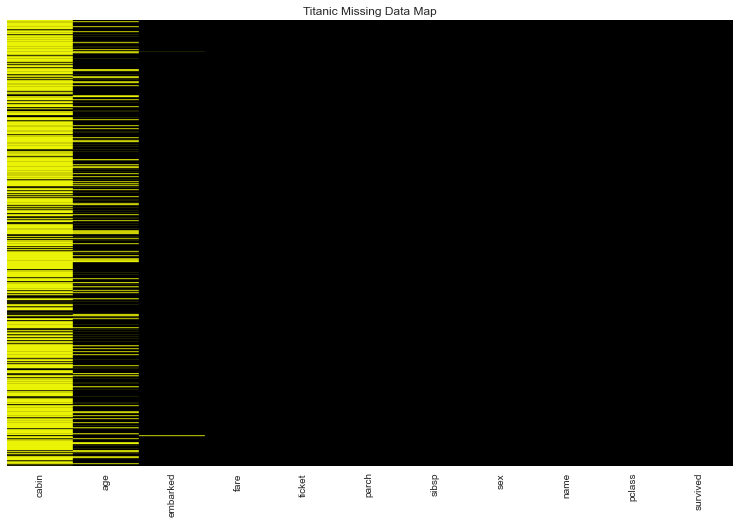

In [2]:
fig, ax = plt.subplots(figsize=(13, 8))
ax = missmap(df, title='Titanic Missing Data Map', ax=ax)

Not half bad. The dataset is about the passengers on the Titanic. It's available from [Kaggle](https://www.kaggle.com/c/titanic-gettingStarted).

### Implementation

Everything is done in a single function, which I've posted in a [gist](https://gist.github.com/TomAugspurger/9156696). *Note: I'm working on getting line numbers to show up in the blog. You may want to follow that link to the gist to see the line numbers I refer to below.*

In [3]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections as collections
from matplotlib.patches import Rectangle
from itertools import izip, cycle


def missmap(df, ax=None, colors=None, aspect=4, sort='descending',
            title=None, **kwargs):
    """
    Plot the missing values of df.

    Parameters
    ----------
    df : pandas DataFrame
    ax : matplotlib axes
        if None then a new figure and axes will be created
    colors : dict
        dict with {True: c1, False: c2} where the values are
        matplotlib colors.
    aspect : int
        the width to height ratio for each rectangle.
    sort : one of {'descending', 'ascending', None}
    title : str
    kwargs : dict
        matplotlib.axes.bar kwargs

    Returns
    -------
    ax : matplotlib axes

    """
    if ax is None:
        fig, ax = plt.subplots()

    # setup the axes
    dfn = pd.isnull(df)

    if sort in ('ascending', 'descending'):
        counts = dfn.sum()
        sort_dict = {'ascending': True, 'descending': False}
        counts.sort(ascending=sort_dict[sort])
        dfn = dfn[counts.index]

    ny = len(df)
    nx = len(df.columns)
    # each column is a stacked bar made up of ny patches.
    xgrid = np.tile(np.arange(len(df.columns)), (ny, 1)).T
    ygrid = np.tile(np.arange(ny), (nx, 1))
    # xys is the lower left corner of each patch
    xys = (zip(x, y) for x, y in izip(xgrid, ygrid))

    if colors is None:
        colors = {True: '#EAF205', False: 'k'}

    widths = cycle([aspect])
    heights = cycle([1])

    for xy, width, height, col in izip(xys, widths, heights, dfn.columns):
        color_array = dfn[col].map(colors)

        rects = [Rectangle(xyc, width, height, **kwargs)
                 for xyc, c in zip(xy, color_array)]

        p_coll = collections.PatchCollection(rects, color=color_array,
                                             edgecolor=color_array, **kwargs)
        ax.add_collection(p_coll, autolim=False)

    # post plot aesthetics
    ax.set_xlim(0, nx)
    ax.set_ylim(0, ny)

    ax.set_xticks(.5 + np.arange(nx))  # center the ticks
    ax.set_xticklabels(dfn.columns)
    for t in ax.get_xticklabels():
        t.set_rotation(90)

    # remove tick lines
    ax.tick_params(axis='both', which='both', bottom='off', left='off',
                   labelleft='off')
    ax.grid(False)

    if title:
        ax.set_title(title)
    return ax


I think my method is about the most straightforward way to do this. I represent each point in the DataFrame as a rectangle.
Every rectangle is the same size. They differ only in their color, which is determined by whether the value is valid or missing.

My first implemenation used Matplotlib's `ax.bar()` and simply stacked the points on top of eachother, similar to [this example](http://matplotlib.org/examples/pylab_examples/bar_stacked.html). However, matplotlib is a memory hog when plotting a lot of points or patches. Because my method means one patch per data point, the original implementation was slow.

The solution was to use a [`Collection`](http://matplotlib.org/api/collections_api.html#module-matplotlib.collections), which is designed for this task.

Line 39 takes the original `DataFrame` and returns a `DataFrame` of `bool`, `True` wherever there is a `NaN` in `df`.

The `if` block starting on line 41 handles how the columns are sorted along the x-axis of the plot.

The next section is some more setup. `matplotlib.patches.Rectangle` expects 3 arguments:

- `(x, y)`: a tuple giving the lower-left corner of the rectangle
- width: a float giving the width
- height: a float giving the height

I create two 2-d arrays, `xgrid` and `ygrid`. Each of these is an `nx` (# of columns) by `ny` (# of rows) matrix.

Here's what they look like:

```python
>>>xgrid
array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 1,  1,  1, ...,  1,  1,  1],
       [ 2,  2,  2, ...,  2,  2,  2],
       ..., 
       [ 8,  8,  8, ...,  8,  8,  8],
       [ 9,  9,  9, ...,  9,  9,  9],
       [10, 10, 10, ..., 10, 10, 10]])

>>>ygrid
array([[  0,   1,   2, ..., 415, 416, 417],
   [  0,   1,   2, ..., 415, 416, 417],
   [  0,   1,   2, ..., 415, 416, 417],
   ..., 
   [  0,   1,   2, ..., 415, 416, 417],
   [  0,   1,   2, ..., 415, 416, 417],
   [  0,   1,   2, ..., 415, 416, 417]])
```

We'll zip the two together to get the `(x, y)` needed for the lower-left corner of each rectangle. So the first point gets
`(xgrid[0][0], ygrid[0][0])`, which is `(0, 0)`. Every point in the same column has the same `x` coordinate, and each point's `y` coordinate is bumped up by one.

Line 53:

```python
xys = (zip(x, y) for x, y in izip(xgrid, ygrid))
```

returns a generator who's elements are the lower left coordinates for each point. I do it lazily with `izip` from the `itertools` module, since we don't need the entire list of tuples at once.

The user can specify what colors to use for True and False, and the aspect ratio.
Initially I was going to create an `nx` by `ny` matrix of widths and heights. But, since every rectangle will be the same shape, I realized that would be wasteful. We can just make a generator that always returns the same number using `itertools.cycle`.

Line 61 is where the action occurs. We iterate over 4 iterables, the lower left coordinates, the widths, the heights, and the columns of the `DataFrame`. For each column in `df`, we create an array of colors, based on which values are `NaN`s.

Line 64 makes a list of `Rectangels` for that column of `df` using a list comprehension. Notice that I don't specify the color of each rectangle here. That's what I did at first, but those colors get overridden by line 67, when you create the `PatchCollection`. That is apparently the correct place to specify the color of each rectangle. The `PatchCollection` is added to the `axes`, `ax`.

The rest is purely aesthetic stuff: getting the x-labels from the columns of `df`, centering and rotating them, removing the labels and ticks from the y axis, and setting a title.

Overall I was pleased with how it turned out. Let me know if you have any suggestions for improvement!